In [1]:
from econ_regime.econ_regime import *
from price.macro_info import get_econ_info
from price.price_processing import *
from strategy.factors.momentum import *
from strategy.factors.volatility import *
from strategy.factors.beta import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

### 주식 저변동성

In [2]:
indexes_df = asset_indicators()

equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

equity_universe = equity_df.loc['2011':,].dropna(axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
signal_df = Volatility(equity_universe).volatility()

### 투자비중

In [4]:
vol_ew_weight = Equalizer(signal=signal_df, rebal_price=equity_universe.resample('M').last(), param=12).ew()

In [5]:
factor_portval = calculate_portvals(price_df=equity_universe.loc['2012':,], weight_df=vol_ew_weight, signal_df=signal_df,long_only=True)
factor_daily_rets = port_rets(factor_portval, cumulative=False)
factor_cum_rets = port_rets(factor_portval, cumulative=True)

factor_daily_rets.to_csv('result/vol_daily_rets.csv')

In [6]:
factor_cum_rets

date_time
2012-01-31    1.000000
2012-02-01    1.003577
2012-02-02    1.003473
2012-02-03    1.006672
2012-02-06    1.005192
                ...   
2022-12-23    3.246341
2022-12-27    3.253113
2022-12-28    3.223930
2022-12-29    3.235479
2022-12-30    3.218526
Length: 2711, dtype: float64

### factor cumulative returns

Total Returns: 321.85%
CAGR: 11.48%
Annualized Volatility: 13.99%
Skewness: -0.53
Kurtosis: 30.59
Max Drawdown: -35.77%
Max Drawdown Duration: 426.00 days
Annualized Sharp Ratio: 0.53
Annualized Sortino Ratio: 0.93
Annualized Calmar Ratio: 0.32
Annualized VaR: -0.02
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.55
Annualized GtP Ratio: 0.96


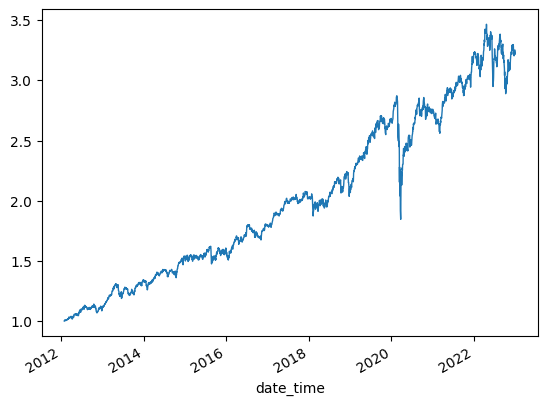

In [7]:
factor_cum_rets.plot(lw=1)
Metric(portfolio=factor_cum_rets, freq='day').print_report()#numeric_metric(dict=False)

AxesSubplot(0.125,0.11;0.775x0.77)


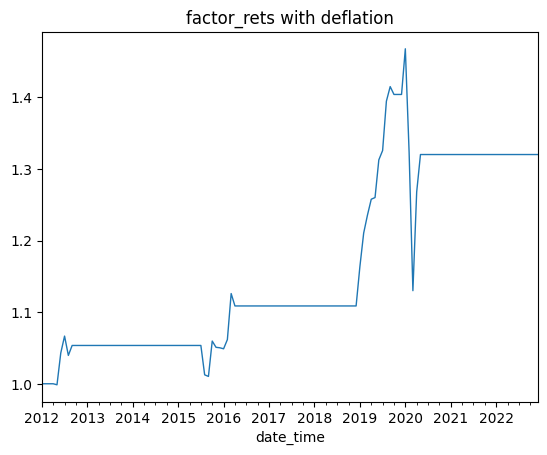

AxesSubplot(0.125,0.11;0.775x0.77)


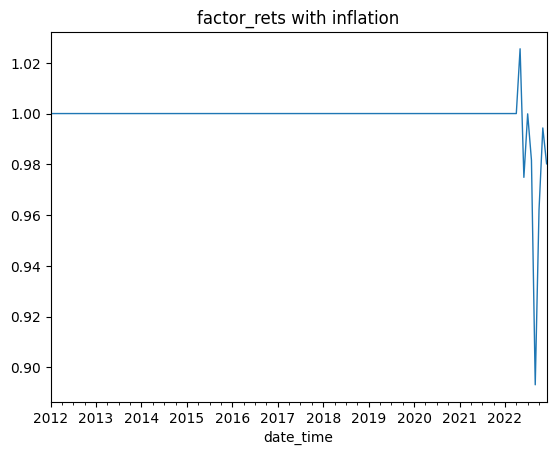

AxesSubplot(0.125,0.11;0.775x0.77)


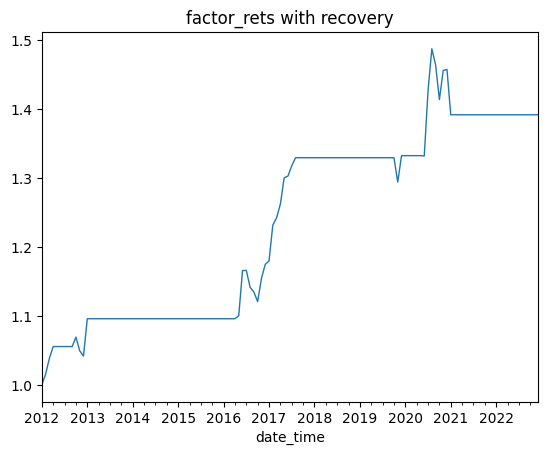

AxesSubplot(0.125,0.11;0.775x0.77)


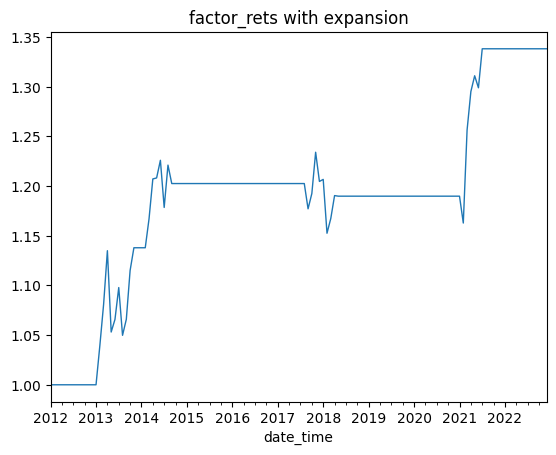

In [8]:
regime_df = business_cycle()
regime_df = regime_df.loc['2012-01':'2022-12']
regime_df.index = factor_daily_rets.resample('M').last().index

fr_df = factor_with_regime(regime_df, factor_cum_rets.resample('M').last().pct_change().fillna(0), 'factor_rets')#.dropna()
check_factor_with_regime(fr_df, 'factor_rets', 'month', plot=True)

### 시황별 성과 확인

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


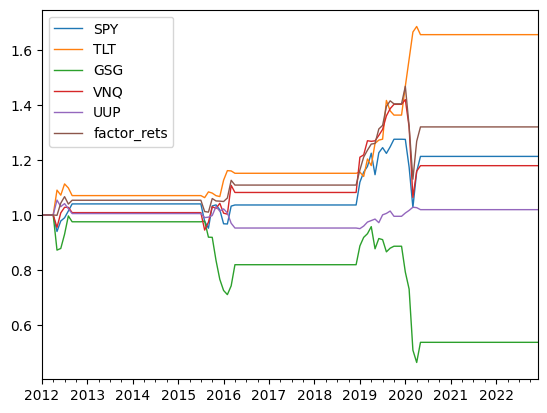

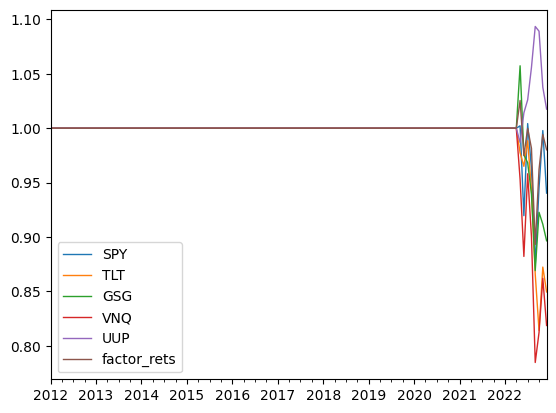

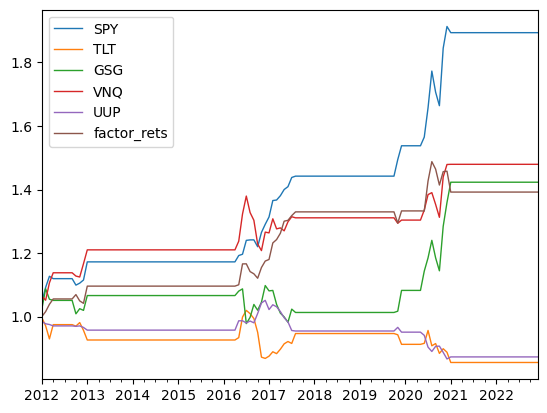

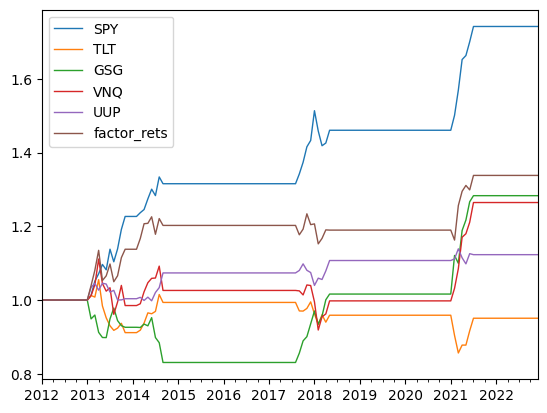

In [9]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

ma_regime_df = multi_asset_df(asset_df, fr_df)
check_best_regime(ma_regime_df, 'month', _plot=True)

### 결과에 따라 투자해보자
- ma_regime_df.loc[(ma_regime_df.recovery == 1),'SPY'] = 1
- ma_regime_df.loc[(ma_regime_df.expansion == 1),'SPY'] = 1
- ma_regime_df.loc[(ma_regime_df.deflation == 1),'factor_rets'] = 1
- ma_regime_df.loc[(ma_regime_df.inflation == 1),'UUP'] = 1

In [10]:
alternate_asset_list = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
invest_price = invest_asset_df(indexes_df, factor_cum_rets, alternate_asset_list)

rebal_list = rebal_dates(invest_price, period='month')
rebal_price_df = price_on_rebal(invest_price, rebal_list)

In [11]:
invest_price

,SPY,TLT,GSG,VNQ,UUP,factor_rets,CASH
date_time,,,,,,,
2012-01-31,106.700012,92.835709,33.770000,40.016430,21.247902,1.000000,1.000159
2012-02-01,107.634399,91.772240,33.750000,40.412056,21.151844,1.003577,1.000317
2012-02-02,107.805054,91.733742,33.730000,40.502853,21.161453,1.003473,1.000476
2012-02-03,109.316299,89.762482,34.009998,41.067104,21.161453,1.006672,1.000635
2012-02-06,109.243233,90.655708,34.169998,40.937401,21.171059,1.005192,1.000794
...,...,...,...,...,...,...,...
2022-12-23,382.910004,101.897858,21.090000,82.739998,27.980000,3.246341,1.546014
2022-12-27,381.399994,99.883034,21.240000,82.709999,27.969999,3.253113,1.546259
2022-12-28,376.660004,99.294556,21.040001,81.300003,28.070000,3.223930,1.546504


In [12]:
regime_asset_dict = {'recovery': 'SPY', 
                    'expansion': 'SPY', 
                    'deflation': 'factor_rets', 
                    'inflation': 'UUP'
                    }

In [13]:
regime_signal_df = regime_signal(ma_regime_df, regime_asset_dict)

regime_signal_df.to_csv('result/vol_regime_signal.csv')

In [14]:
regime_signal_df.sum(axis=1).sum()

132

In [15]:
regime_weight = Equalizer(signal=regime_signal_df, rebal_price=rebal_price_df, param=12).ew()
regime_weight = regime_weight.fillna(0)
regime_weight

,SPY,TLT,GSG,VNQ,UUP,factor_rets,CASH
2012-01-31,1.0,0,0,0,0.0,0.0,0.0
2012-02-29,1.0,0,0,0,0.0,0.0,0.0
2012-03-31,1.0,0,0,0,0.0,0.0,0.0
2012-04-30,1.0,0,0,0,0.0,0.0,0.0
2012-05-31,0.0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
2022-08-31,0.0,0,0,0,1.0,0.0,0.0
2022-09-30,0.0,0,0,0,1.0,0.0,0.0
2022-10-31,0.0,0,0,0,1.0,0.0,0.0
2022-11-30,0.0,0,0,0,1.0,0.0,0.0


In [16]:
regime_port = calculate_portvals(price_df=invest_price, weight_df=regime_weight, signal_df=regime_signal_df, long_only=True)
daily = port_rets(regime_port, False)

daily.to_csv('result/vol_regime_daily.csv')

Total Returns: 385.71%
CAGR: 13.57%
Annualized Volatility: 13.25%
Skewness: -0.59
Kurtosis: 38.81
Max Drawdown: -35.41%
Max Drawdown Duration: 376.00 days
Annualized Sharp Ratio: 0.72
Annualized Sortino Ratio: 1.20
Annualized Calmar Ratio: 0.38
Annualized VaR: -0.02
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.66
Annualized GtP Ratio: 0.65


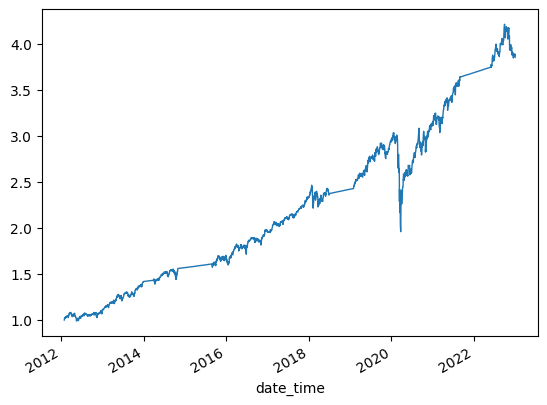

In [17]:
port_rets(regime_port, True).plot(lw=1)
Metric(portfolio=port_rets(regime_port, True)).print_report()